In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Lable Encode for non-numerical lable
le = LabelEncoder()
le.fit(y)
print(le.classes_)
y = le.transform(y)
#y_org = le.inverse_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''
# Create a decision tree classifier
model = DecisionTreeClassifier()

# Define hyperparameter grid
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
'''
# Define the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.01, 0.02, 0.03],
}

# Set up stratified K-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Get best hyperparameters and model
best_model = grid_search.best_estimator_
print("Best parameters: ", grid_search.best_params_)
print("Best training score: ", grid_search.best_score_)

# Evaluate best model on test set
train_score = best_model.score(X, y)
print("Train accuracy:", train_score)
test_score = best_model.score(X_test, y_test)
print("Test accuracy:", test_score)

#predictions = best_model.predict(X_test)
#accuracy = accuracy_score(y_test, predictions)
#print("Test accuracy:", accuracy)


[0 1 2]
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Best training score:  0.9583333333333334
Train accuracy: 0.98
Test accuracy: 1.0


In [26]:
X.shape

(150, 4)

In [4]:
import torch
torch.randint(0,3,(X.shape[0],))

tensor([1, 0, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 2, 0, 2, 0,
        1, 1, 2, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2, 1, 2, 0,
        2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 0, 2, 2, 0, 2, 1,
        1, 2, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2,
        0, 0, 1, 1, 0, 2, 2, 0, 2, 1, 2, 1, 2, 0, 1, 2, 2, 0, 0, 2, 1, 0, 2, 2,
        2, 1, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 2,
        0, 1, 1, 1, 0, 2])

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, X_Catg, y):
        self.X = X
        self.X_Catg = X_Catg
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.X_Catg[idx], self.y[idx]
    
# Define a simple model with 2 linear layers
class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_catg, num_classes):
        super(ClassificationModel, self).__init__()
        self.hidden_dim = 16
        self.input_size = input_size
        self.num_catg = num_catg 
        self.num_classes = num_classes
        self.emb = nn.Embedding(num_catg, self.hidden_dim)
        self.linear1 = nn.Linear(input_size, self.hidden_dim)  # Hidden layer
        self.linear2 = nn.Linear(self.hidden_dim, num_classes)  # Output layer

    def forward(self, x, xc):
        x = torch.relu(self.linear1(x) + self.emb(xc))  # Apply ReLU activation
        x = self.linear2(x)
        return x

num_catg = 9

# create dataset and dataloader
train_dataset = MyDataset(
    torch.from_numpy(X).type(torch.float32), 
    torch.randint(0,num_catg,(X.shape[0],)),
    torch.from_numpy(y).type(torch.long),
)
test_dataset = MyDataset(
    torch.from_numpy(X_test).type(torch.float32), 
    torch.randint(0,num_catg,(X_test.shape[0],)),
    torch.from_numpy(y_test).type(torch.long)
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Create the model instance
model = ClassificationModel(input_size=X.shape[1], num_catg=num_catg, num_classes=len(le.classes_)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 25

# Training loop
for epoch in range(num_epochs):
    for xt, xct, yt in train_dataloader:
    # Forward pass
        outputs = model(xt.to(device), xct.to(device))
        loss = criterion(outputs, yt.to(device))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    with torch.no_grad():
        predictions = model(test_dataset.X.to(device), test_dataset.X_Catg.to(device))
        _, predicted_classes = torch.max(predictions.cpu(), 1)
        print("Test accuracy:", accuracy_score(y_test, predicted_classes.numpy()))



Epoch [1/25], Loss: 0.9255
Test accuracy: 0.7
Epoch [2/25], Loss: 0.6025
Test accuracy: 0.7
Epoch [3/25], Loss: 0.5491
Test accuracy: 0.7333333333333333
Epoch [4/25], Loss: 0.4250
Test accuracy: 0.7
Epoch [5/25], Loss: 0.5474
Test accuracy: 0.8
Epoch [6/25], Loss: 0.3492
Test accuracy: 0.7666666666666667
Epoch [7/25], Loss: 0.4537
Test accuracy: 0.8
Epoch [8/25], Loss: 0.4734
Test accuracy: 0.8333333333333334
Epoch [9/25], Loss: 0.5025
Test accuracy: 0.8333333333333334
Epoch [10/25], Loss: 0.2031
Test accuracy: 0.8666666666666667
Epoch [11/25], Loss: 0.2833
Test accuracy: 0.8333333333333334
Epoch [12/25], Loss: 0.3391
Test accuracy: 0.9333333333333333
Epoch [13/25], Loss: 0.0673
Test accuracy: 0.9666666666666667
Epoch [14/25], Loss: 0.3606
Test accuracy: 0.9666666666666667
Epoch [15/25], Loss: 0.2758
Test accuracy: 0.9666666666666667
Epoch [16/25], Loss: 0.0526
Test accuracy: 0.8666666666666667
Epoch [17/25], Loss: 0.0602
Test accuracy: 0.8666666666666667
Epoch [18/25], Loss: 0.0896
Te

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model (here, a simple CNN)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and transform the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Instantiate the model and optimizer
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(2):  # Loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


In [13]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

(array([50., 50., 50.]), array([0, 1, 2, 3]), <a list of 3 Patch objects>)

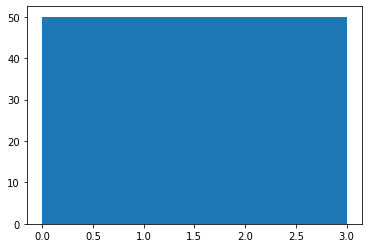

In [16]:
import matplotlib.pyplot as plt
plt.hist(y, bins=[0,1,2,3])